# TextMining CW2
### Jie Wang &emsp; Rong Jian Yee &emsp; Hao Cao &emsp; Zhiyuan Zhao

### Main Tasks
1. What is the domiant sentiment towards large language models such as OpenAI's ChatGPT and others?
2. What are the pros and cons of these large language models that people have been discussing?
3. What field will large language models be most beneficial and useful in the future?

---

# Data generating

1. Using the API search_tweets of version 4.0+ to acquire the data from twitter.
2. Convert all tweets from list to dataframe.
3. Store the data in csv file.

In [3]:
import tweepy
import pandas as pd
import time

auth = tweepy.OAuthHandler('BcWEliOxF0h6v9VWpUlNtS5nU', 'HfW6WHnnPqB5BkodYKgMTAihGbmEjioJpP3DhAekLLtVeb6xIi')
auth.set_access_token('841021709209731073-rRR8mlOkIw7pLGEnplp03nWwnYOGwJ3', 'Aa2c8dlmUOKzsRRRc0v6gELtKbJFAkcNwNzOe9T6uuCUQ')

api = tweepy.API(auth, wait_on_rate_limit=True) #

# Collect tweets
query = "#chatgpt" + " -filter:retweets"
# cutoff_date = "2023-03-05"
tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", count=100).items(2000)

tweets_list = [[tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tweets_df = pd.DataFrame(data=tweets_list, columns=['date', 'user', 'location', 'text'])

# A good idea to save downloaded tweets as CSV
tweets_df.to_csv ('./resources/chatgpt.csv', quotechar='"', encoding='utf8', index = False, header=True)
print("Finish data generation.")

Rate limit reached. Sleeping for: 603


Finish data generation.


---

# Data cleaning

1. Mainly using the regular expression to do the data cleaning.
2. Utilising the set to remove the duplicate tweets.

In [2]:
# Load the regular expression library
import re
import pandas as pd

# Make sure that line below is uncommented, if you are loading data from a provided/previously saved CSV
tweets_df = pd.read_csv('./resources/chatgpt.csv', quotechar='"', encoding='utf8')

# Remind the type of 'text' column, convert to string before using the map
tweets_df['text'] = tweets_df['text'].values.astype(str)

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text'].map(lambda x: re.sub('[,\\.!?]', ' ', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

# Strip the https
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'https://t [a-zA-Z+]*','',x))

#Strip the senseless pattern
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'/[A-Za-z0-9]*','',x))

# pattern of emoji
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)

# Strip the emoji
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: emoji_pattern.sub(r'',x))

# Think of how else your data can be cleaned

# Set the option to display full details of processed string
pd.set_option('display.max_colwidth', None)

# Print out the first rows 
print(tweets_df['text_processed'].head())

# Removing duplicate tweets?
unique_tweets = list(set(list(tweets_df['text_processed'].values)))
unique_tweets = [t for t in unique_tweets if t]

# print(unique_tweets)

0     #weatherupdate #islamabad #isb #pakistan #tempupdate #sunrise #sunset #hourlyupdatesunrise: 06:24 am sunset: 06:11… 
1    we use #ai in our lives all the time  but with tools like #chatgpt trending  there's new dialogue around what it me… 
2          for #chatgpt the limits of its language (model) are the limits of its world  - wittgenstein was right (again)  
3    respecting the rule of law  and promoting unity and dialogue  rather than promoting or advocating for violence or c… 
4                      how to use chatgpt to unlock new levels of innovation#entrepreneurship #chatgpt #innovation #levels
Name: text_processed, dtype: object


---

# Using word cloud

1. Try to generate the word cloud of previous tweets.

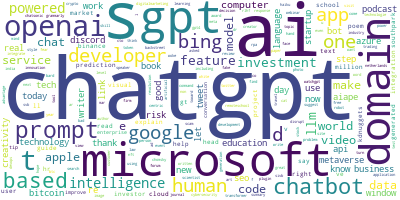

In [7]:
from wordcloud import WordCloud

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

---

# Topic modelling

1. Download the nltk stopwords.
2. Use the gensim to do simple preprocess of sentences.
3. Remove the stopwords in sentences.

In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from pprint import pprint

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"chatgpt" + 0.010*"amp" + 0.010*"ai" + 0.007*"new" + 0.006*"like" + '
  '0.005*"get" + 0.004*"openai" + 0.004*"corporate" + 0.003*"data" + '
  '0.003*"news"'),
 (1,
  '0.076*"chatgpt" + 0.028*"ai" + 0.008*"new" + 0.007*"chatbot" + '
  '0.006*"openai" + 0.005*"like" + 0.005*"using" + 0.005*"data" + '
  '0.004*"chatgptprompts" + 0.004*"world"'),
 (2,
  '0.072*"chatgpt" + 0.031*"ai" + 0.013*"openai" + 0.011*"gpt" + '
  '0.009*"microsoft" + 0.005*"chatbot" + 0.005*"new" + 0.005*"next" + '
  '0.005*"like" + 0.004*"azure"'),
 (3,
  '0.065*"chatgpt" + 0.027*"ai" + 0.006*"like" + 0.005*"openai" + 0.004*"gpt" '
  '+ 0.003*"marketing" + 0.003*"better" + 0.003*"tools" + 0.003*"new" + '
  '0.003*"tech"'),
 (4,
  '0.056*"chatgpt" + 0.020*"ai" + 0.010*"amp" + 0.004*"via" + 0.004*"project" '
  '+ 0.004*"get" + 0.003*"world" + 0.003*"interesting" + 0.003*"new" + '
  '0.003*"gpt"')]


# Visualise the topics

1. Set the data filepath.
2. Save the data at the resources folder.
3. Load the data file and generate the LDAvis.

In [12]:
import os
import pyLDAvis.gensim as gensimvis  #remind that pyLDAvis.gensim_models is newer one
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./resources/'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './resources/'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.073922  0.051379       1        1  27.394975
1      0.008669  0.047974       2        1  24.945553
3      0.013055 -0.034300       3        1  19.214853
4      0.011443 -0.090546       4        1  15.674717
0     -0.107088  0.025493       5        1  12.769902, topic_info=              Term       Freq       Total Category  logprob  loglift
68             amp  74.000000   74.000000  Default  30.0000  30.0000
1303     corporate  23.000000   23.000000  Default  29.0000  29.0000
1451  incorporated  19.000000   19.000000  Default  28.0000  28.0000
1452     readiness  19.000000   19.000000  Default  27.0000  27.0000
1412      strategy  21.000000   21.000000  Default  26.0000  26.0000
...            ...        ...         ...      ...      ...      ...
163            gpt   7.942064  104.513796   Topic5  -5.7304  -0.5191
550            via   6.177520   37.068232   Topic5  -5.9817   0.2662
124           good   5.999408   34.866060   Topic5  -6.0109   0.2982
235           help   5.904327   34.310260   Topic5  -6.0269   0.2983
369          write   5.677708   32.298997   Topic5  -6.0661   0.3196

[381 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2558      5  0.836187         actions
1322      3  0.882017       advantage
3282      3  0.763837           ahead
3282      5  0.190959           ahead
7         1  0.340465              ai
...     ...       ...             ...
542       5  0.444275            yolo
937       1  0.242058         youtube
937       2  0.121029         youtube
937       4  0.484116         youtube
4890      5  0.920149  zimmadarshehri

[725 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

---

# Sentiment analysis
# Task 1 What is the domiant sentiment towards large language models such as OpenAI's ChatGPT and others?

1. Install the vaderSentiment.
2. Use the analyzer.

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# Create a dictionary for the results.
vsResults = {}

# Count for the dictionary
count = 0

for tweet_text in unique_tweets:
    vs = analyzer.polarity_scores(tweet_text)
    vsResults[count] = [tweet_text,vs]
    count += 1
#     print(tweet_text + '\t' + str(vs))

# The volumn of the tweets, equals to the variable count
volumn = count

# Just print to observe the results
for i in range(10):
    print(str(i)+":  ",str(vsResults[i][0])+"\t"+str(vsResults[i][1]))
    
# Create the dictionary of final result for four sentiments
sentimentResults = {'neg':0.0,'neu':0.0,'pos':0.0}
# Calculate the general sentiment of the tweets about chatgpt
for i in range(volumn):
    sentimentResults['neg'] += float(vsResults[i][1]['neg'])
    sentimentResults['neu'] += float(vsResults[i][1]['neu'])
    sentimentResults['pos'] += float(vsResults[i][1]['pos'])

res = max(sentimentResults, key = lambda x: sentimentResults[x])
print("\nThe main sentiment towards ChatGPT is: ",res)

0:   email marketing laws 21   #chatgpt #chatgptprompts #chatbot #chatbotai #aichatbot #ai… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
1:   we put #chatgpt to the test for various #digitalmarketingagency tasks … how did it fare  you’ll have to check out t… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2:   i will provide 70 forum posts with unique forums site for rankingclick here: #seo… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
3:   chatgpt integrated into cybersecurity products as industry tests its capabilitieschatgpt is increasingly integrate… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
4:   revolution in world of artificial intelligence#abbtakk #chatgpt #artificialintelligence   watch video:… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
like   #news  #investing  #stocks  #stockstobuy  #stockstowatch  #investments  #daytrading… 	{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'compound': 0.3612}
6:   chatgpt's ai-made sport is constru

---

# Named Entity Recognition

1. Install the spacy.
2. Load the nlp model.
3. Get the result of nlp model.

In [26]:
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')

ModuleNotFoundError: No module named 'en_core_web_trf'

In [ ]:
for tweet_text in unique_tweets:
  doc = nlp(tweet_text)
  print(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, tweet_text[ne.start_char:ne.end_char])

new rise in #chatgpt scams reported by #fraudsters   #cybersecurity #cybercrime #hacking… 
poker experts overwhelmingly support the use of ai  with 93% in favor of it  40% of those surveyed said ai has elev… 
	NE found:  57 60 PERCENT 93%
	NE found:  77 80 PERCENT 40%
in the era of #chatgpt and artificial intelligence tools which make real life look like science fiction  google tra… 
#chatgpt-like artificial intelligence is a "game-changer" in smart #finance  bringing both opportunities and challe… 
 is ready for acquisition  #ai #artificialintelligence #gpt #gpt3 #chatgpt #haptic… 
chatgpt is one of the most mind-bending technologies we've come across great resource for #chatgpt prompts … 
	NE found:  11 14 CARDINAL one
$cdt is multi-chain already 2 chain added and next #arbitrum and #aptos #crypto #chatgpt #binance #kucoin… 
	NE found:  28 29 CARDINAL 2
everyone wants to climb the corporate ladder  so write like the boss  #ghostwriter for microsoft #office with… 
	NE found:  87 96 OR

---

# Named Entity Linking

This implementation is based on [spaCy Entity Linker](https://github.com/egerber/spacy-entity-linker).

In [ ]:
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_md

import en_core_web_md
from spacy.language import Language

In [ ]:
from spacy_entity_linker import EntityLinker

# !python -m spacy_entity_linker "download_knowledge_base"

nlp = spacy.load("en_core_web_md")

#add to pipeline
nlp.add_pipe('entityLinker', last=True)

In [ ]:
for tweet_text in unique_tweets:
  try:
    doc = nlp(tweet_text)
    print(tweet_text)
    all_linked_entities = doc._.linkedEntities
    for linked_entity in all_linked_entities:
      print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
  except:
    pass


new rise in #chatgpt scams reported by #fraudsters   #cybersecurity #cybercrime #hacking… 
https://www.wikidata.org/wiki/Q1139344 rise  => grade <tangent of the angle of a surface to the horizontal>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q3510521 cybersecurity  => computer security <The protection of computer systems from theft or damage>
https://www.wikidata.org/wiki/Q14948222 fraudsters  => con artist <individual who exploits characteristics of the human psyche such as dishonesty, honesty, vanity, etc.>
https://www.wikidata.org/wiki/Q25222539 hacking  => hacking <banned rugby football tactic>
https://www.wikidata.org/wiki/Q29137 cybercrime  => computer crime <any crime that involves a computer and a network>
poker experts overwhelmingly support the use of ai  with 93% in favor of it  40% of those surveyed said ai has elev… 
https://www.wikidata.org/wiki/Q8

---

# Task 2 What are the pros and cons of these large language models?

1. Define the function of utilising the grammatical formats for searching pros and cons
2. According to the compound score, using the pre-defined function to extract the pros and cons of chatgpt
3. Perform Data cleaning for the outputs of pros and cons

### 1. Define the function of utilising the grammatical formats for searching pros and cons

In [ ]:
# some shortcomings that should be improved: ignore the adv words after verbs

def find_prosandcons(results, pog_sentence):

    doc = nlp(pog_sentence)
    for token in doc:
        if token.pos_ == 'VERB':
            dependents = token.children
            for d in dependents:

                token_text = token.text

                if d.dep_ == 'prep':
                    token_text = token_text + ' ' + d.text
                    for pobjs in d.children:
                        if pobjs.dep_ == 'pobj':
                            token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)

                elif d.dep_ == 'agent':
                    token_text = token_text + ' ' + d.text
                    for pobjs in d.children:
                        if pobjs.dep_ == 'pobj':
                            token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)

                elif d.dep_ == 'dobj':
                    token_text = token_text + ' ' + find_d_p_obj(d)
                    for preps in d.children:
                        if preps.dep_ == 'prep':
                            token_text = token_text + ' ' + preps.text
                            for pobjs in preps.children:
                                if pobjs.dep_ == 'pobj':
                                    token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)
                
                elif d.dep_ == 'acomp':
                    token_text = token_text + ' ' + d.text
                    for preps in d.children:
                        if preps.dep_ == 'prep':
                            token_text = token_text + ' ' + preps.text
                            for pobjs in preps.children:
                                if pobjs.dep_ == 'pobj':
                                    token_text = token_text + ' ' + find_d_p_obj(pobjs)
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)
        
        if token.pos_ == 'ADJ':
            dependents = token.children
            for d in dependents:

                token_text = token.text

                if d.dep_ == 'prep':
                    token_text = token_text + ' ' + d.text
                    for pcomps in d.children:
                        if pcomps.dep_ == 'pcomp':
                            token_text = token_text + ' ' + pcomps.text
                            for advmods in pcomps.children:
                                if advmods.dep_ == 'advmod':
                                    token_text = token_text + ' ' + advmods.text
                    if len(token_text.split(' ')) >= 3:
                        results.append(token_text)
    
    return results
    
    # print(results)

    # for token in doc:
    #     print(token.text + '\t' + token.lemma_ + '\t' + token.pos_ + '\t' + token.tag_ + '\t' + token.dep_ + '\t' + str([child.text + ':' + child.dep_ for child in token.children]))

def find_d_p_obj(pobjs):
    amod_text = ''
    for d in pobjs.children:

        if d.dep_ == 'det':
            amod_text = amod_text + d.text + ' '

        elif d.dep_ == 'amod':
            amod_text = amod_text + d.text + ' '
    
    token_text = amod_text + pobjs.text

    return token_text

# find_prosandcons([], unique_tweets[173])

### 2. According to the compound score, using the pre-defined function to extract the pros and cons of chatgpt

In [ ]:
pros = []
cons = []

# During the expriment, it is observed that the tweets which have compound score higher than 0.1 would provide the sensible information of pros.
# During the expriment, it is observed that the tweets which have compound score lower than -0.4 would provide the reasonable information of cons.

for index, tweet_text in enumerate(unique_tweets):
    vs = analyzer.polarity_scores(tweet_text)
    neg, neu, pos, compound = vs['neg'], vs['neu'], vs['pos'], vs['compound']
    if compound > 0.1: 
        pros = find_prosandcons(pros, tweet_text)
    if compound < -0.4: # 
        cons = find_prosandcons(cons, tweet_text)

In [ ]:
# The results of pros without cleaning

for i in pros:
    print(i)

support the use of ai
support with %
look like tra
bringing both opportunities
come across great resource
come for # prompts
climb the corporate ladder
write like the boss
program compact version of aaltoaivo
program for dynamic music
use what service
watch live sports
recommend joyful iptv
done an indian version of kudos
dealing with artificial legislation
dealing for year
curious about integrate how # ai prepare how
bouncing daily zones
made to this performance
ai by niall
applied in telecom
know about the latest update
get this update
join a waitlist
write a story about it
fall in love
saved countless hours
studying with examcram
studying with help
highered in #
learning under l
panic logout to account
working for the people
organized in abbottabad فیصل_آباد_میں_امید_سحر#سراج_الحق_کوئٹہ_دھرنا#chatgpt
reads like glorified chatgpt awful hackneyed writing
disrespects a brilliant artist
asked # chatgpt
look during reviews
raised more questions
access this free resource
features based re

In [ ]:

# The results of cons without cleaning

for i in cons:
    print(i)

reported by cybersecurity
broken in chatgpt
chat with #
make a point
according to data
tracks killings in the states
making a lot of mistakes
coming to prediction
talking in a year
talking about this
take a look at top questions
disruptions implications of
protest against use
protest against chatgpt
changing the world
replaced by ai
laugh given # incompetence
cry at the
inventing fake apis
do than the dynamical physical models
warns of rise
notes emergence of sophisti
using # chatgpt
scam unsuspecting people
scam via chat
asked # chatgpt
write a portrait of @drtlaleng
transformed into an chatbot
fight # directive
work towards a ch
making the most of this insane
lie to you
use # blogspot
promote in an organic way
getting problem to access
get on $ fallout
rolls generated conversation
taking to the next level
transferring into a talkative chatbot
integrates chatgpt with own discord
according to minorities
benefited by lower rates
have a political chatgpt
do the heavy lifting
do with a sn

### 3. Perform Data cleaning for the outputs of pros and cons

In [ ]:

# 1: remove the pharses which ends up with 'a', 'an', 'it', ...
# 2: remove the pharses having fewer than 3 words, which has been done in the function find_prosandcons()

ends_up_words = ['%', '+', 'in', 'it', 'vc', '#', 'a', 'an', 'the', 'lil', 're', 'se', 'lm', 'ep', 'ch', 'e(|x|', 'f(x', '∞', 'sta', '=']

for i in range(10): # ends up with numbers
    ends_up_words.append(str(i))

upperletters = [chr(i) for i in range(65, 91)] # ends up with upperletters
lowerletters = [chr(i) for i in range(97, 123)] # ends up with lowerletters

for i in range(26):
    ends_up_words.append(upperletters[i])
    ends_up_words.append(lowerletters[i])

print(ends_up_words)

pros_results = []
cons_results = []

for pharse in pros:
    
    if pharse.split(' ')[-1] not in ends_up_words:
        pros_results.append(pharse)

for pharse in cons:
    
    if pharse.split(' ')[-1] not in ends_up_words:
        cons_results.append(pharse)


['%', '+', 'in', 'it', 'vc', '#', 'a', 'an', 'the', 'lil', 're', 'se', 'lm', 'ep', 'ch', 'e(|x|', 'f(x', '∞', 'sta', '=', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'a', 'B', 'b', 'C', 'c', 'D', 'd', 'E', 'e', 'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'O', 'o', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', 'T', 't', 'U', 'u', 'V', 'v', 'W', 'w', 'X', 'x', 'Y', 'y', 'Z', 'z']


In [ ]:
# The results of pros

for i in pros_results:
    print(i)

support the use of ai
look like tra
bringing both opportunities
come across great resource
come for # prompts
climb the corporate ladder
write like the boss
program compact version of aaltoaivo
program for dynamic music
use what service
watch live sports
recommend joyful iptv
done an indian version of kudos
dealing with artificial legislation
dealing for year
curious about integrate how # ai prepare how
bouncing daily zones
made to this performance
ai by niall
applied in telecom
know about the latest update
get this update
join a waitlist
fall in love
saved countless hours
studying with examcram
studying with help
panic logout to account
working for the people
organized in abbottabad فیصل_آباد_میں_امید_سحر#سراج_الحق_کوئٹہ_دھرنا#chatgpt
reads like glorified chatgpt awful hackneyed writing
disrespects a brilliant artist
asked # chatgpt
look during reviews
raised more questions
access this free resource
features based reasons
ai in education
watch as @fergal_reid
wait for an ai
resolve an

In [ ]:
# The results of cons

for i in cons_results:
    print(i)

reported by cybersecurity
broken in chatgpt
make a point
according to data
tracks killings in the states
making a lot of mistakes
coming to prediction
talking in a year
talking about this
take a look at top questions
disruptions implications of
protest against use
protest against chatgpt
changing the world
replaced by ai
laugh given # incompetence
inventing fake apis
do than the dynamical physical models
warns of rise
notes emergence of sophisti
using # chatgpt
scam unsuspecting people
scam via chat
asked # chatgpt
write a portrait of @drtlaleng
transformed into an chatbot
fight # directive
making the most of this insane
lie to you
use # blogspot
promote in an organic way
getting problem to access
get on $ fallout
rolls generated conversation
taking to the next level
transferring into a talkative chatbot
integrates chatgpt with own discord
according to minorities
benefited by lower rates
have a political chatgpt
do the heavy lifting
do with a snap
turns any page
turns into ea
turned in

---

# Task 3 What fields will chatgpt be most useful in the future?

1. Give a list of words which are relevant to the ability to do something in the future
2. Seize the positive sentiment sentences and launch the tokenization to them
3. Use the nlp processor to find the initial form of future words and every positive sentence
4. Find the Nouns which appear most frequently in these sentences containing future words

### 1. Give a list of words which are relevant to the ability to do something in the future

In [ ]:
future_words_origin = 'future prosperous prosperity can could better performance useful available futural improvement enhancement scale development evolve evolution improve predict will would beneficial impact effect influence intelligent intellectualisation'
future_words = []

for token in nlp(future_words_origin):
    # print(token.text + '\t' + token.lemma_ + '\t' + token.pos_ + '\t' + token.tag_ + '\t' + token.dep_ + '\t' + str([child.text + ':' + child.dep_ for child in token.children]))
    future_words.append(token.lemma_)

print(future_words)

['future', 'prosperous', 'prosperity', 'can', 'could', 'well', 'performance', 'useful', 'available', 'futural', 'improvement', 'enhancement', 'scale', 'development', 'evolve', 'evolution', 'improve', 'predict', 'will', 'would', 'beneficial', 'impact', 'effect', 'influence', 'intelligent', 'intellectualisation']


 ### 2. Seize the positive sentiment sentences and launch the tokenization to them
 ### 3. Use the nlp processor to find the initial form of future words and every positive sentence
 ### 4. Find the Nouns which appear most frequently in these sentences containing future words

In [ ]:
future_noun_words = {}

def frequences(dict, word):
    if word in dict.keys():
        dict[word] += 1
    else:
        dict[word] = 1

# chatgpt is defintely in the final results, and defintely should be removed
def useful_words(word):
    if word not in ends_up_words and word not in stop_words and word[0] != '@' and word not in future_words and word != 'chatgpt':
        return True
    else:
        return False

for index, tweet_text in enumerate(unique_tweets):
    vs = analyzer.polarity_scores(tweet_text)
    neg, neu, pos, compound = vs['neg'], vs['neu'], vs['pos'], vs['compound']
    if compound > 0.1: # and pos >= neu and pos >= compound
        # print(index, tweet_text)
        tweet_text_token = nlp(tweet_text)
        for token in tweet_text_token:
            if token.lemma_ in future_words:
                for nouns in tweet_text_token:
                    if nouns.pos_ == 'NOUN' and useful_words(nouns.lemma_):
                        frequences(future_noun_words, nouns.lemma_)
                break

future_noun_words = sorted(future_noun_words.items(), key=lambda item:item[1], reverse = True)

for i in future_noun_words:
    print(i)


('ai', 19)
('tool', 12)
('video', 11)
('technology', 10)
('way', 9)
('week', 9)
('work', 8)
('business', 8)
('chatbot', 7)
('time', 7)
('innovation', 6)
('intelligence', 6)
('marketing', 6)
('customer', 5)
('world', 5)
('prompt', 5)
('today', 5)
('link', 5)
('content', 5)
('openai', 5)
('model', 5)
('programming', 5)
('developer', 5)
('experience', 5)
('day', 4)
('question', 4)
('issue', 4)
('research', 4)
('article', 4)
('writing', 4)
('domain', 4)
('news', 4)
('game', 4)
('task', 4)
('job', 4)
('cybersecurity', 4)
('software', 4)
('system', 4)
('copy', 4)
('seo', 4)
('thank', 4)
('support', 3)
('telecom', 3)
('hour', 3)
('science', 3)
('gpt4', 3)
('datum', 3)
('team', 3)
('result', 3)
('site', 3)
('user', 3)
('view', 3)
('gpt', 3)
('year', 3)
('education', 3)
('product', 3)
('chat', 3)
('text', 3)
('number', 3)
('ability', 3)
('startup', 3)
('service', 3)
('ad', 3)
('part', 3)
('expert', 3)
('language', 3)
('researcher', 3)
('malware', 3)
('llm', 3)
('kid', 3)
('idea', 3)
('example',

---